# UPA Projekt - 2. část

**Autoři:** *Tým sUPerlAtivů* - Filip Jahn (xjahnf00), Michal Luner (xluner01), Vojtěch Staněk (xstane45)

**Zvolená datová sada:** Most Streamed Spotify Songs 2023 (soubor spotify-2023.csv)

**Dolovací úloha:** Predikce oblíbenosti písně na základě ostatních atributů (např.: rytmus písně, tónina, mód písně apod.)

## Příprava

In [264]:
#region imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#endregion

#region helper functions

def convertAndFillNulls(data):
    data['in_shazam_charts'].fillna(0, inplace=True) # in_shazam_charts ma null hodnoty, ktere vyplnime 0 pro snadnou konverzi
    data['in_deezer_playlists'].fillna(0, inplace=True) # in_shazam_charts ma null hodnoty, ktere vyplnime 0 pro snadnou konverzi
    data['in_deezer_playlists'] = data['in_deezer_playlists'].replace(',', '', regex=True).astype('int64') # nektere hodnoty byly v americkem formatu, kde 2,456 znaci 2456
    data['in_shazam_charts'] = data['in_shazam_charts'].replace(',', '', regex=True).astype('int64')

    attributes_to_convert = ['streams', 'in_deezer_playlists', 'in_shazam_charts']

    # Convert each specified column to numeric values
    for attribute in attributes_to_convert:
        data[attribute] = pd.to_numeric(data[attribute], errors='coerce', downcast='integer')
        data[attribute].fillna(0, inplace=True)

    # Convert the columns to integer type
    data[attributes_to_convert] = data[attributes_to_convert].astype('Int64')
    data['key'] = data['key'].fillna('Unknown')
    data = data.dropna(how='any')

#endregion

## Explorativní analýza



### Průzkum atributů datové sady

Průzkum jednotlivých atributů datové sady, jejich typ a hodnoty, kterých nabývají (počet hodnot, nejčastější hodnoty, rozsah hodnot atd.)


Načtení datasetu, kontrolní výpis hlavičky pro prvotní přehled, výpis atributů (sloupců) v datasetu

In [214]:
data = pd.read_csv('./spotify-2023.csv', encoding='latin-1')
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [215]:
data.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

Souhrnné informace o datasetu

In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

Už z tohoto výstupu můžeme vidět, že některé položky mají nevyplněnou hodnotu (menší počet `non-null` hodnot). Zároveň je nevhodné, aby zřejmě numerický atribut (`streams`, `in_deezer_playlists`, `in_shazam_charts`) neměl numerický datový typ.

Zjistíme tedy, které všechny atributy mají kategorický datový typ.

In [217]:
# identifikace kategorickych atributu
categorical_attributes = [col for col in data.columns if data[col].dtype != 'int64']
print(f"Kategorické atributy: {categorical_attributes}")

Kategorické atributy: ['track_name', 'artist(s)_name', 'streams', 'in_deezer_playlists', 'in_shazam_charts', 'key', 'mode']


Ostatní atributy, které mají být zřejmě numerické (`streams`, `in_deezer_playlists`, `in_shazam_charts`) převedeme na odpovídající datový typ. Zároveň nevyplněné (`null`) hodnoty nahradíme implicitní hodnotou, tj. nula v případě počtu výskytu v žebříčcích (`in_deezer_playlists`, `in_shazam_charts`) a `Unknown` v případě tóniny.

In [218]:
# prevod na odpovidajici datovy typ a vyplneni 'default' null hodnot
convertAndFillNulls(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    Int64 
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    Int64 
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      953 non-null    Int64 
 14  bpm                   953 non-null    int64 
 15  key                   953 non-null    ob

Pro **numerické atributy** vypisujeme základní statistiky, z čehož bychom už potenciálně mohli odhalit nějaké odlehlé hodnoty.

In [219]:
data.describe().round(0)

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0,953.0
mean,2.0,2018.0,6.0,14.0,5200.0,12.0,513597931.0,68.0,52.0,385.0,3.0,57.0,123.0,67.0,51.0,64.0,27.0,2.0,18.0,10.0
std,1.0,11.0,4.0,9.0,7898.0,20.0,566803887.0,86.0,51.0,1131.0,6.0,157.0,28.0,15.0,23.0,17.0,26.0,8.0,14.0,10.0
min,1.0,1930.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,23.0,4.0,9.0,0.0,0.0,3.0,2.0
25%,1.0,2020.0,3.0,6.0,875.0,0.0,141381703.0,13.0,7.0,13.0,0.0,0.0,100.0,57.0,32.0,53.0,6.0,0.0,10.0,4.0
50%,1.0,2022.0,6.0,13.0,2224.0,3.0,290228626.0,34.0,38.0,44.0,0.0,2.0,121.0,69.0,51.0,66.0,18.0,0.0,12.0,6.0
75%,2.0,2022.0,9.0,22.0,5542.0,16.0,673801126.0,88.0,87.0,164.0,2.0,33.0,140.0,78.0,70.0,77.0,43.0,0.0,24.0,11.0
max,8.0,2023.0,12.0,31.0,52898.0,147.0,3703895074.0,672.0,275.0,12367.0,58.0,1451.0,206.0,96.0,97.0,97.0,97.0,91.0,97.0,64.0


Z tabulky je patrné, že například hodnoty roku vydání jsou v rozsahu od 1930 až po aktuální rok 2023.

Podobně např. z počtu streamů můžeme zjistit, že největší počet streamů je 3,7 mld., zatímco nejmenší počet streamů je 2762, průměr streamů je 514 mil. se směrodatnou odchylkou 567 mil. Z toho můžeme usoudit, že počty streamů se mohou výrazně lišit a kolísat.

Podobně jako u numerických atributů lze describe funkci využít i pro **kategorické atributy**. Z výstupů můžeme zjistit, kolik hodnot je v datasetu celkově, kolik těchto hodnot je unikátních, zároveň se vypisuje i hodnota nejčastějšího výskytu atributu.

In [220]:
data.describe(include = ['object'])

,track_name,artist(s)_name,key,mode
count,953,953,953,953
unique,943,645,12,2
top,Daylight,Taylor Swift,C#,Major
freq,2,34,120,550


### Průzkum rozložení hodnot

Průzkum rozložení hodnot jednotlivých atributů pomocí vhodných grafů se zaměřením na vztahy mezi atributy.

#### Rozložení hodnot numerických atributů

Využijeme zobrazení matice grafů pro průzkum rozložení hodnot všech atributů

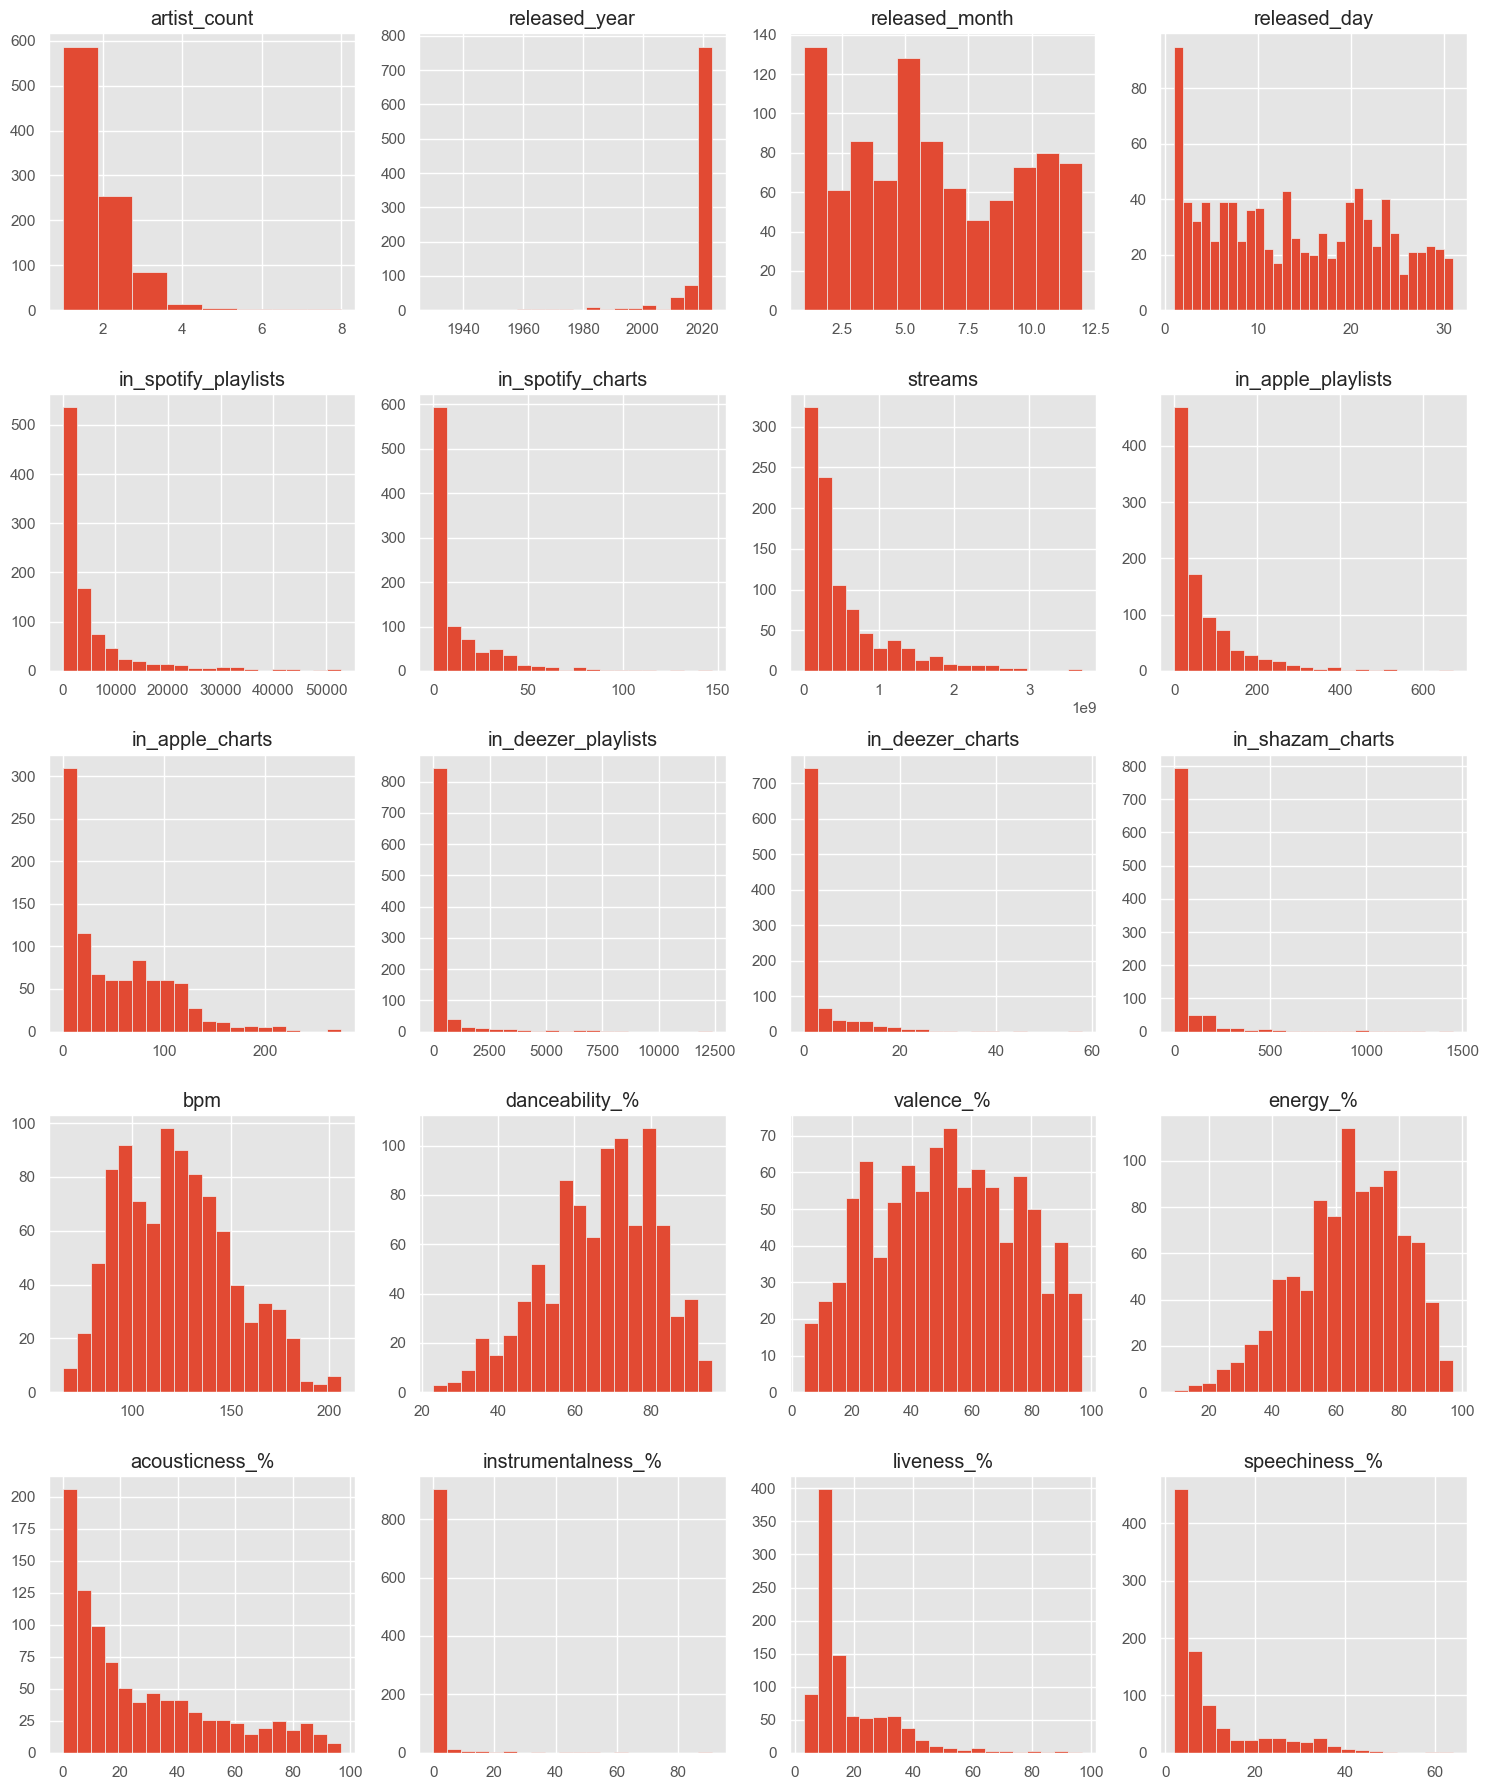

In [221]:
# Get numerical attributes only
numerical_attributes = data.select_dtypes(include='int64')

# Custom histogram bins, default to 20 by using .get() method
custom_atrrib_bins = {
    "artist_count": 8,
    "released_month": 12,
    "released_day": 31,
}

# Display in a matrix
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 18))

# Histogram for each attribute
for i, col in enumerate(numerical_attributes.columns):
    title = col.title().lower()

    b = custom_atrrib_bins.get(title, 20)
    r = i // 4
    c = i % 4
    data[col].hist(bins = b, ax = axes[r, c])
    axes[r, c].set_title(col)

# Show histogram matrix
plt.tight_layout()
plt.show()

Z matice grafů můžeme vyčíst velké množství informací. 
- V prvním řádku vidíme, že nejčastější počet interpretů podílejících se na písničce je nejčastěji roven 1. Nejpopulárnější je, co se do počtu streamů týče, soudobá hudba. Zároveň nejčastější měsíce pro vydání nové písničky jsou leden a květen, většinou na začátku měsíce.
- Na dalším řádku vidíme sadu playlistů a žebříčků jednotlivých platforem, kde rozložení bývá podobné, tj. nejstreamovanější hudba nemusí být nutně na čelech žebříčků. To, že nejsou ani v playlistech, by se dalo vysvětlit tak, že jelikož se jedná o nové písně, ještě se nedostaly do playlistů (a dojde k tomu teprve později).
- Další sada grafů se zaobírá akustickými vlastnostmi hudby. Už z těchto grafů vidíme, že je preferována spíše hudba s vyšší mírou danceability a energy, naopak hudba s výraznými prvky acousticness, instrumentalness, liveness ani speechiness populární tolik není.

V následujících grafech můžeme vidět nejstreamovanější písničky včetně odpovídajícího počtu streamů a nejstreamovanější interprety, tj. co se do počtu písní od daného interpreta v datové sadě.

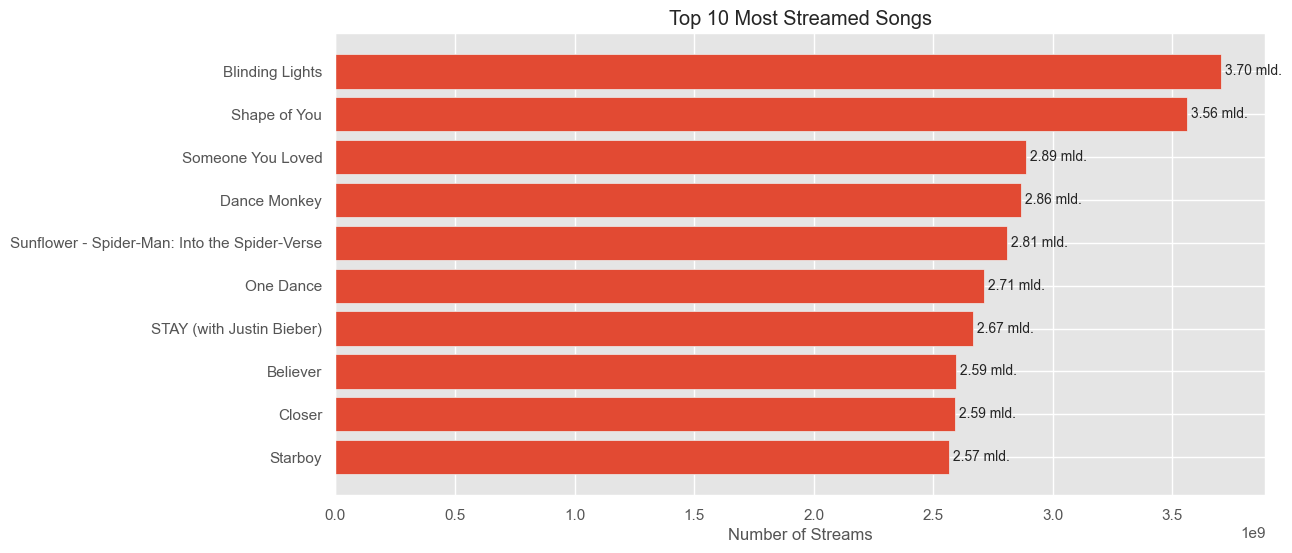

In [222]:
new_data = data.dropna(subset=['streams', 'track_name'])

# Get the 10 most streamed songs
top_10_songs = new_data.nlargest(10, 'streams')[['track_name', 'streams']]
top_10_songs = top_10_songs.sort_values(by='streams', ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_10_songs['track_name'], top_10_songs['streams'])
plt.xlabel('Number of Streams')
plt.title('Top 10 Most Streamed Songs')
for index, value in enumerate(top_10_songs['streams']):
    displayyy = f" {value/1e9:.2f} mld."
    plt.text(value, index, displayyy, ha='left', va='center')

plt.show()

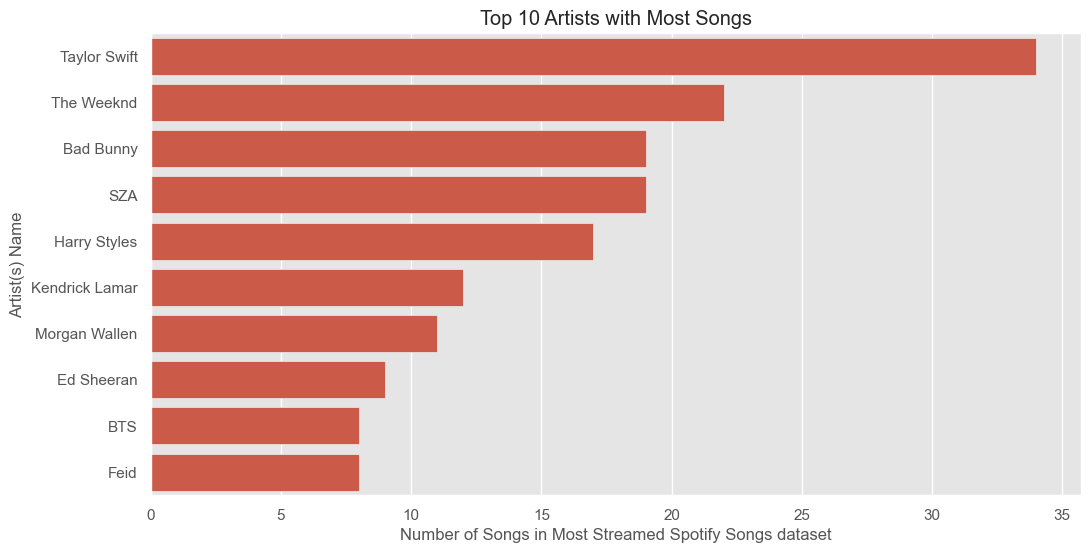

In [223]:
top_artists = data['artist(s)_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.xlabel('Number of Songs in Most Streamed Spotify Songs dataset')
plt.ylabel('Artist(s) Name')
plt.title('Top 10 Artists with Most Songs')
plt.show()

Následující graf popisuje zastoupení preferencí, co se do klíče písně týče. Nejpopulárnější je očividně C#, nicméně obecně další preference nejsou a na základě tohoto atributu nelze úplně jasně predikovat, který klíč zaručí úspěch (mimo jiné právě hodnota klíče často chyběla).

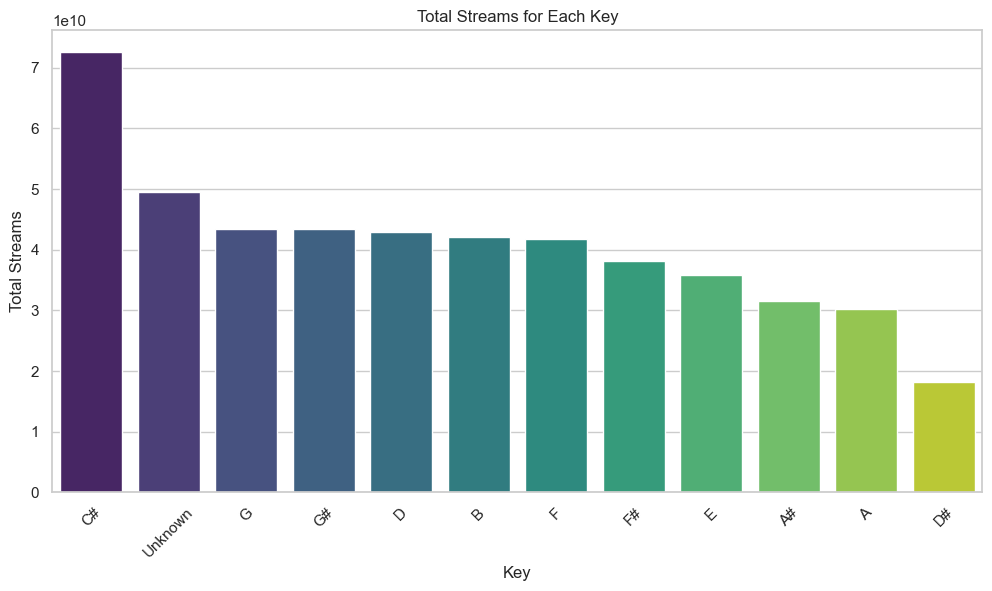

In [224]:
key_streams = data.groupby('key')['streams'].sum().reset_index()

key_streams = key_streams.sort_values(by='streams', ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='key', y='streams', data=key_streams, hue='key', palette='viridis')
plt.xlabel("Key")
plt.ylabel("Total Streams")
plt.title("Total Streams for Each Key")
plt.xticks(rotation=45) 
plt.show()

Sada grafů níže popisuje trendy akustických vlastností na základě let. Můžeme například vidět, že okolo 40. let 20. st. v hudebním průmyslu po válce interpretům nebylo příliš do tance, naopak však přibyly hodnoty atributu acousticness.

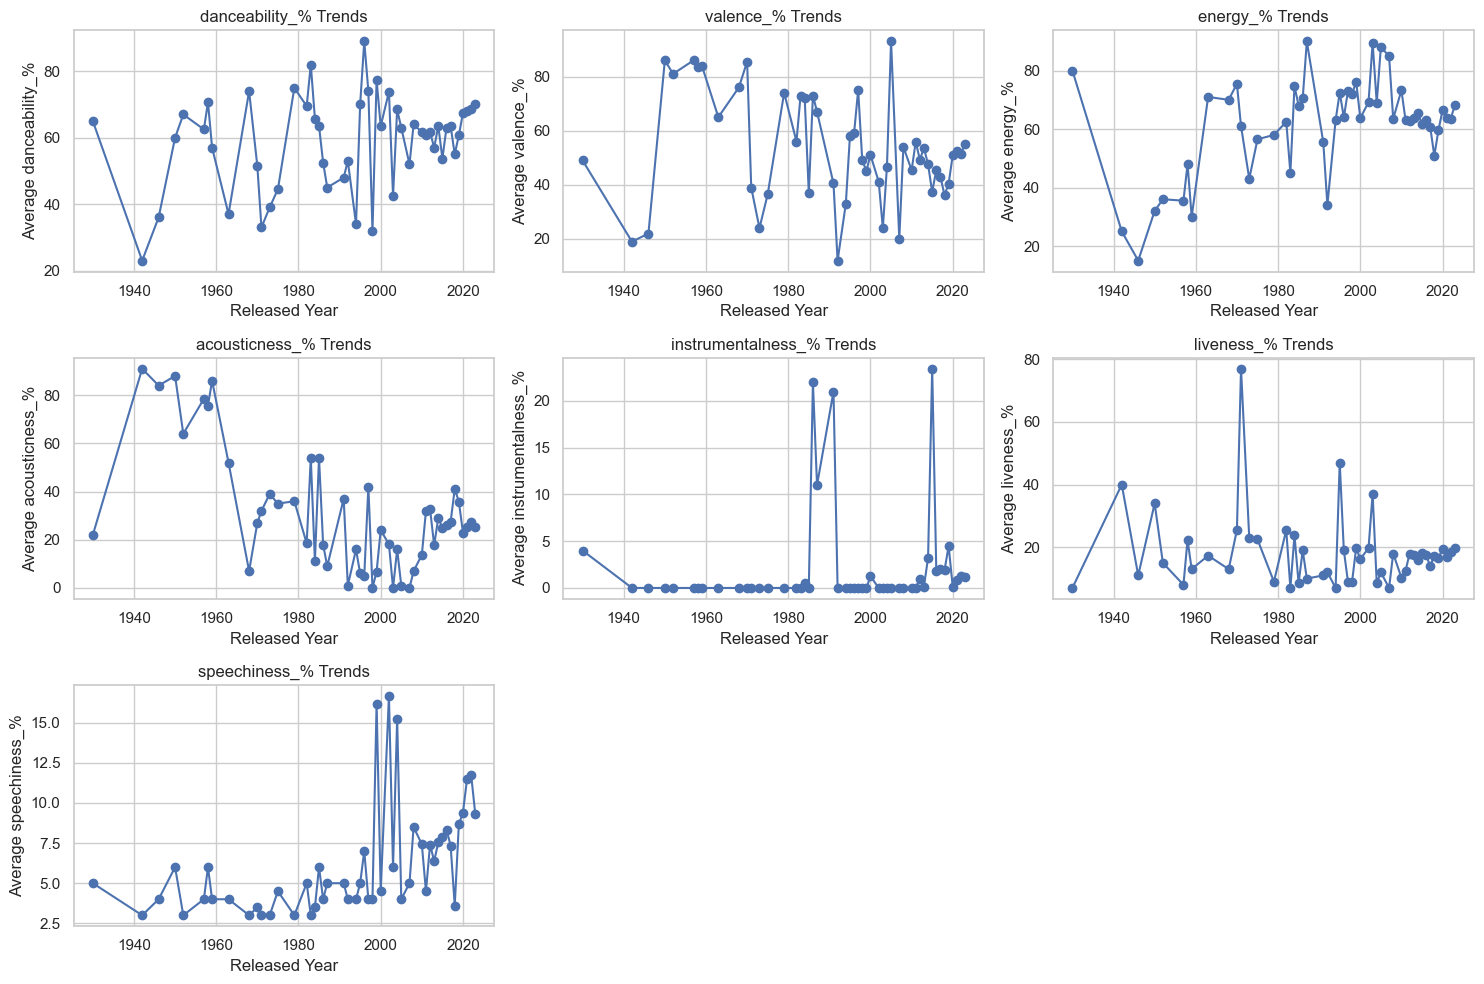

In [225]:
acoustic_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

# Calculate average for each acoustic feature for each year
average_acoustic_features = data.groupby('released_year')[acoustic_features].mean().reset_index()

# Plot trends in acoustic features over the years
plt.figure(figsize=(15, 10))

for i, feature in enumerate(acoustic_features, 1):
    plt.subplot(3, 3, i)
    plt.plot(average_acoustic_features['released_year'].to_numpy(), average_acoustic_features[feature].to_numpy(), marker='o')
    plt.xlabel("Released Year")
    plt.ylabel(f"Average {feature}")
    plt.title(f"{feature} Trends")

plt.tight_layout()
plt.show()

Další sada grafů poskytuje náhled na to, jak jednotlivé akustické vlasnosti ovlivňují streamovanost. Z grafů nevidíme zcela jednoznačné ukazatele, které by měly vliv na streamovanost, avšak vidíme preference ve vyšších hodnotách atributů energy a naopak nižší hodnoty v instrumentalness, liveness a speechiness. Obecně tak lze říci, že posluchači preferují skladby obsahující více zpěvu na úkor řeči a instrumentálním prvkům.

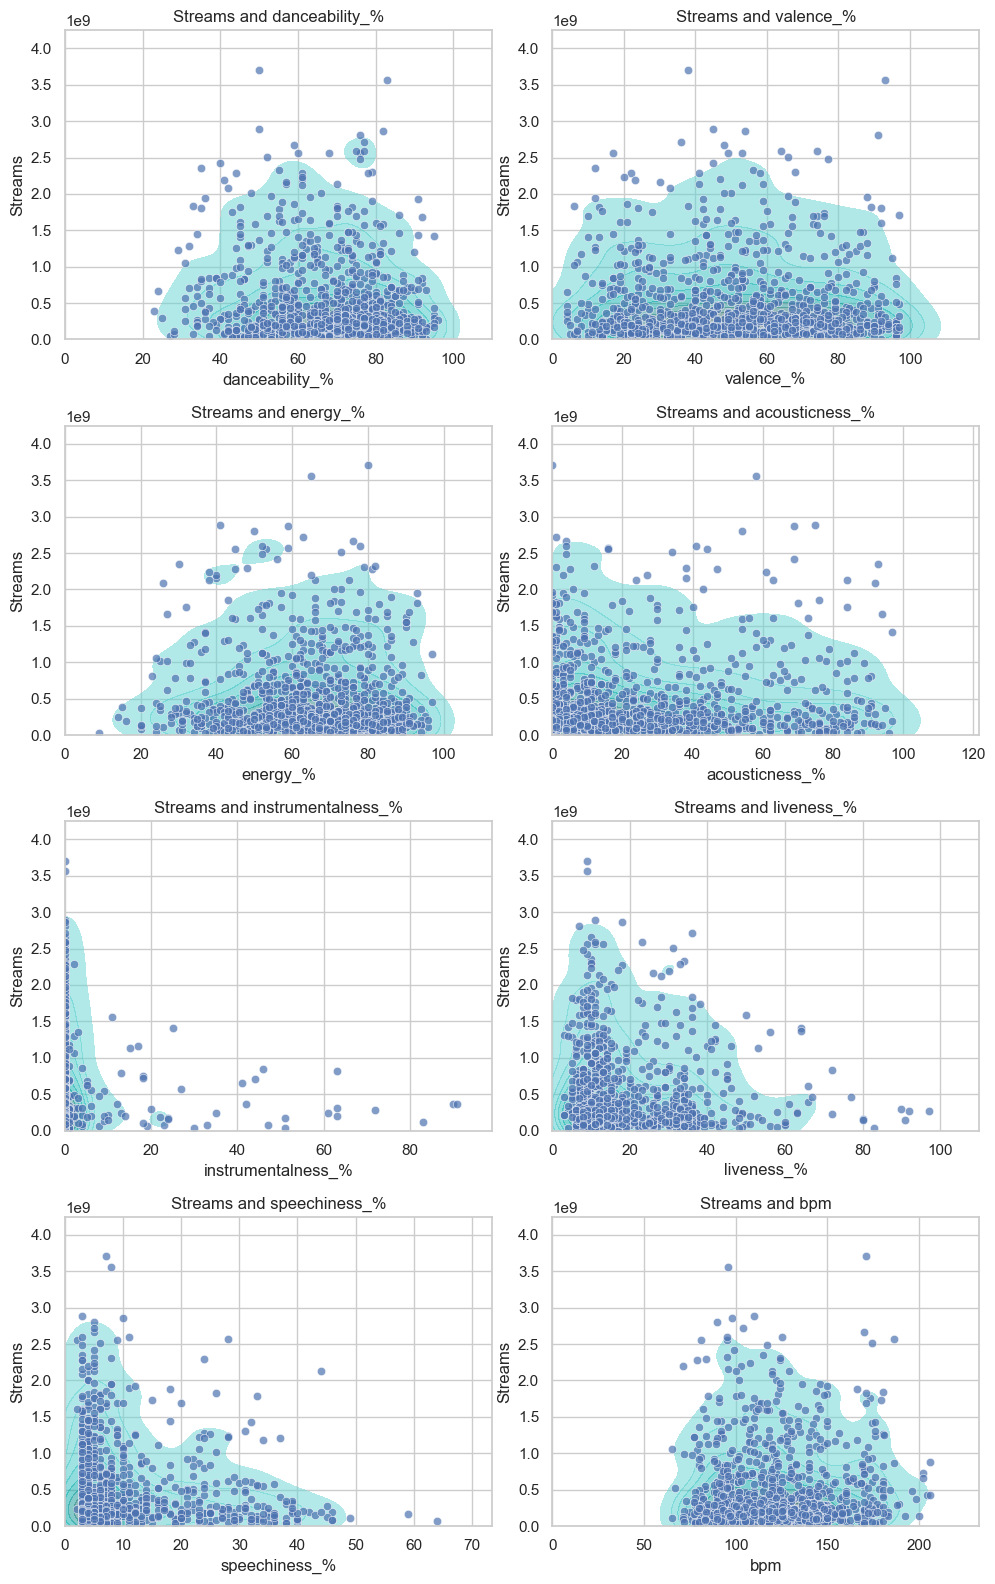

In [226]:
acoustic_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'bpm']

# Set the style of seaborn
sns.set(style="whitegrid")

# Create subplots for each acoustic feature
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 16))
axes = axes.flatten()

for i, feature in enumerate(acoustic_features):
    sns.kdeplot(y='streams', x=feature, data=data, ax=axes[i], color="cyan", fill=True, alpha=0.5)
    sns.scatterplot(y='streams', x=feature, data=data, alpha=0.7, ax=axes[i])
    axes[i].set_ylabel("Streams")
    axes[i].set_xlabel(f"{feature}")
    axes[i].set_ylim(ymin = 0)
    axes[i].set_xlim(xmin = 0)
    axes[i].set_title(f"Streams and {feature}")

# Adjust layout
plt.tight_layout()
plt.show()

### Analýza odlehlých hodnot

K detekci a analýze odlehlých hodnot lze využít několika přístupů:
1. Vizualizační techniky (krabicové grafy)
2. Numerické výpočty (IQR, identifikace odlehlých hodnot za pomocí z-score normalizace)

U odlehlých hodnot je třeba mít na paměti, že i když se může jednat o nějakou extrémní hodnotu, neimplikuje to nutně to, že by se jednalo o chybnou hodnotu.

Jelikož hledáme odlehlé hodnoty, uvažujeme, že null hodnoty máme již vyřešené a atributy máme ve správném formátu, což jsme již provedli funkcí `convertAndFillNulls`.

#### Numerické odlehlé hodnoty

Nejdříve z datasetu na základě datového typu vybereme atributy, které jsou numerické.
Z předešlých fází víme, jaké mají atributy zhruba rozsah. Jelikož chceme nejdříve zobrazit souhrnné krabicové grafy, rozdělíme atributy tak, aby si vzájemně nekazily měřítko.

Z předešlých fází víme, jaké mají atributy zhruba rozsah. Jelikož chceme nejdříve zobrazit souhrnné krabicové grafy, rozdělíme atributy tak, aby si vzájemně nekazily měřítko.

In [ ]:
# numerical_attributes máme nachystáno z předešlých buněk
numerical_data_playlists_charts = numerical_attributes[["in_spotify_charts", "in_apple_playlists", "in_apple_charts", "in_deezer_charts", "in_shazam_charts"]]
numerical_data_audio_features = numerical_attributes[["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"]]
numerical_data_playlists = numerical_attributes[["in_spotify_playlists", "in_deezer_playlists"]]
numerical_data_others = numerical_attributes[["bpm", "streams"]]

# Playlists and charts
pal1 = sns.color_palette("rainbow", 7)
sns.set_palette(pal1)
fig1, _ = plt.subplots(nrows = 5, ncols = 1, figsize = (15, 8))
fig1.tight_layout()
for i, attrib in enumerate(numerical_data_playlists_charts):
    plt.subplot(5, 1, i+1)
    sns.boxplot(data=numerical_data_playlists_charts[attrib], orient='h', color=pal1[i]) # type: ignore

# Spotify playlists
fig2, _ = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 3))
fig2.tight_layout()
for i, attrib in enumerate(numerical_data_playlists):
    plt.subplot(2, 1, i+1)
    sns.boxplot(data=numerical_data_playlists[attrib], orient='h', color=pal1[6-i]) # type: ignore

Spotify a Deezer playlisty mají svůj graf, jelikož mají znatelně větší hodnoty oproti ostatním atributům. Ač z grafů vidíme velké množství bodů naznačujících odlehlé hodnoty, nemělo by se jednat o chybná data. Je očekávatelné, že průměrně úspěšných písní je větší množství, a tak populárnější kousky vypadají jako odlehlé hodnoty. Zvláštní hodnoty pozorujeme především u žebříčků na platformě Deezer.

Jako další prozkoumáme data a období vydání a počet přispívajích interpretů.

In [250]:
numerical_data_eval = numerical_attributes[["released_year", "released_month", "released_day", "artist_count"]]
numerical_data_eval.describe()

,released_year,released_month,released_day,artist_count
count,953.000000,953.000000,953.000000,953.000000
mean,2018.238195,6.033578,13.930745,1.556139
std,11.116218,3.566435,9.201949,0.893044
min,1930.000000,1.000000,1.000000,1.000000
25%,2020.000000,3.000000,6.000000,1.000000
50%,2022.000000,6.000000,13.000000,1.000000
75%,2022.000000,9.000000,22.000000,2.000000
max,2023.000000,12.000000,31.000000,8.000000


Hodnoty data vydání a počtu přispívajících interpretů je zbytečné zobrazovat graficky. Z tabulky vidíme, že maximální/minimální hodnoty pro rok, měsíc i den dávají smysl, stejně tak počet interpretů na písničku je v rozumných mezích.

V následujících grafech projdeme další dostupné atributy. První složený graf ukazuje jednotlivé aspekty audia v procentech. Rozsah hodnot by tedy měl být v rozmezí 0 až 100, což odpovídá. Zřejmě nejvíce upoutá atribut instrumentalness, který uvádí podíl instrumentální složky v písni. Při manuální analýze objektů, které mají tuto hodnotu vysokou, se potvrdilo, že se skutečně nejedná o chybné hodnoty - tato informace může mimo jiné posloužit i k tomu, že obecně nejstreamovanější hudba je z velké části vokálnější.

Druhý graf pak ukazuje BPM - beats per minute, tedy tempo písničky. Ve třetím grafu je vidět počet streamů. Nejúspěšnější interpreti se svými písněmi dosahují přes 3 mld. poslechů, ale zde se správně jedná o výjimky.

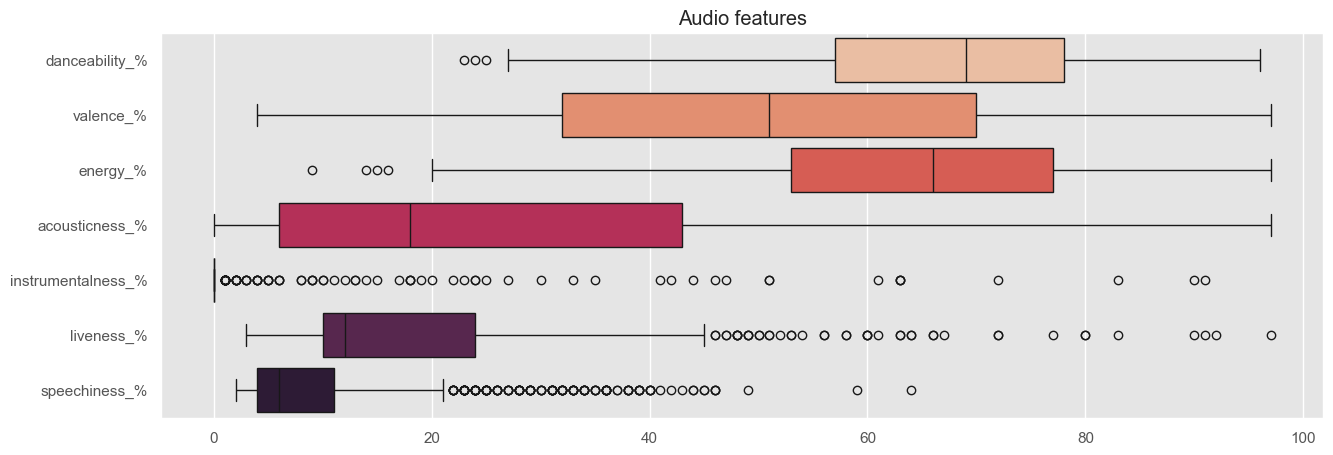

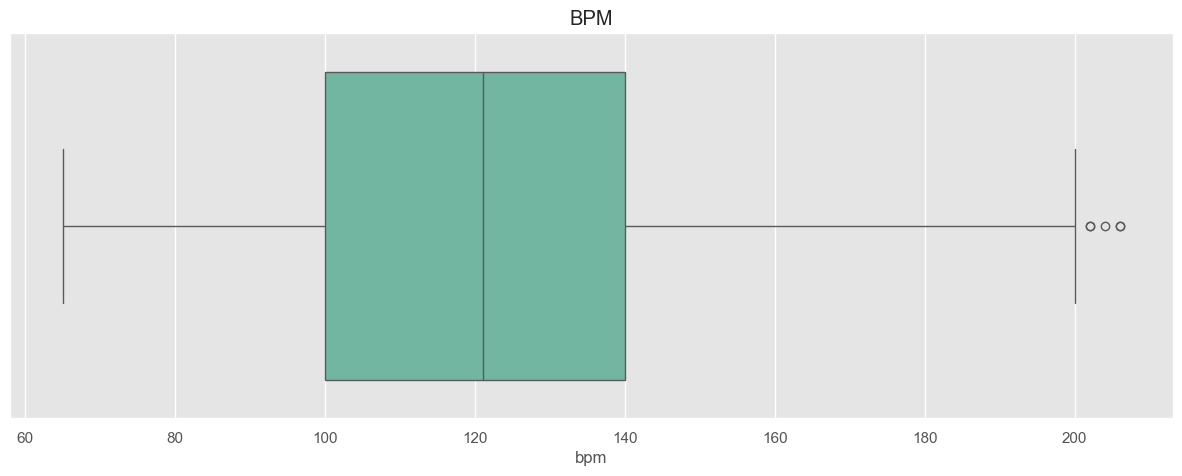

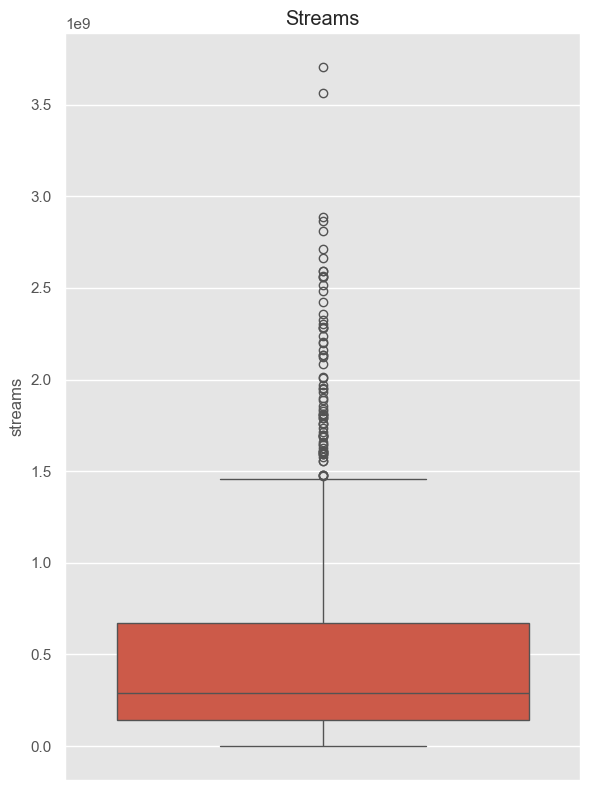

In [270]:
plt.figure(figsize=(15, 5))
# Box plots for audio_features
sns.boxplot(data=numerical_data_audio_features, orient='h', palette='rocket_r')
plt.title('Audio features')

# Box plots for others
plt.figure(figsize=(15, 5))
sns.boxplot(data=numerical_data_others["bpm"], orient='h', palette='Set2')
plt.title('BPM')

# Plot for streams
plt.figure(figsize=(6, 8))
sns.boxplot(data=numerical_data_others["streams"])
plt.title('Streams')

plt.tight_layout()
plt.show()

Alternativnou ke krabicovým grafům jsou ještě houslové grafy, které navíc přináší odhad hustoty.

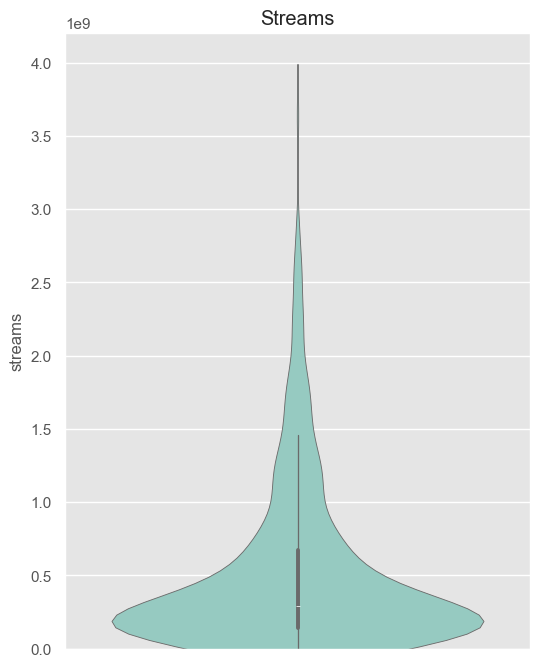

In [285]:
# Violin plot for streams
plt.figure(figsize=(6, 8))
sns.violinplot(data=numerical_data_others["streams"], palette='Set3')
axes = plt.gca()
axes.set_ylim(0)
plt.title('Streams')
plt.show()

#### Kategorické odlehlé hodnoty

V hodnotách kategorických atributů je situace složitější. Je zřejmé, že jméno písně ani interpreta nelze jakkoliv vyhodnocovat. Z atributů, které analyzovat lze, tak zbývají mode a key.

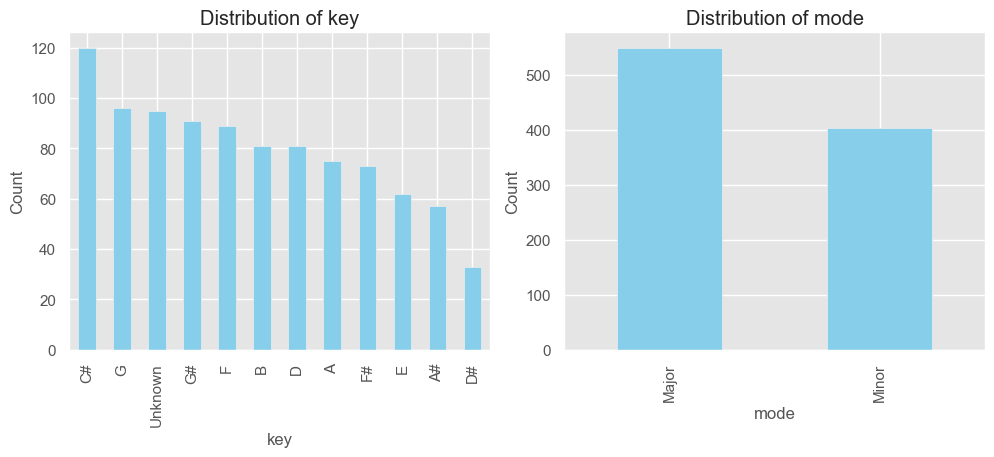

In [286]:
categorical_data = data.select_dtypes(include=['object'])
categorical_data = categorical_data.drop(["track_name", "artist(s)_name"], axis=1)

plt.figure(figsize=(15, 8))
for i, column in enumerate(categorical_data.columns, start=1):
    plt.subplot(2, 3, i)  # Adjust the subplot layout based on the number of categorical attributes
    data[column].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


Hodnota `Unknown` u klíče byla manuálně doplněna na místa, kde hodnota původně nebyla. Tomuto se více věnujeme v sekci **Odstranění chybných hodnot**.

### Analýza chybějících hodnot

Znovu načteme data, abychom je měli v neupravené podobě.

Kód níže lze využít pro kontrolu, jaké unikátní hodnoty pro dané atributy existují (např. jestli místo `null` není v záznamech třeba `?`, který bychom jinak neodhalili). V textovém editoru pak lze projít jednotlivé záznamy.

In [288]:
data = pd.read_csv('./spotify-2023.csv', encoding='latin-1')

In [289]:
for column in data.columns:
    print(f"\nValue counts for '{column}':")
    print(data[column].value_counts())


Value counts for 'track_name':
Daylight                                  2
About Damn Time                           2
SNAP                                      2
Take My Breath                            2
Let It Snow! Let It Snow! Let It Snow!    2
                                         ..
Murder In My Mind                         1
Gangsta's Paradise                        1
CAIRO                                     1
I Love You So                             1
Alone                                     1
Name: track_name, Length: 943, dtype: int64

Value counts for 'artist(s)_name':
Taylor Swift                 34
The Weeknd                   22
Bad Bunny                    19
SZA                          19
Harry Styles                 17
                             ..
Karol G, Ovy On The Drums     1
Coolio, L.V.                  1
Kordhell                      1
Kenia OS                      1
Feid, Sech, Jhayco            1
Name: artist(s)_name, Length: 645, dtype: int64

Val